In [2]:
import sys, os
import argparse
import re
import time
from Deconvolution.BLADE import Framework
import numpy as np
from numpy import transpose as t
import itertools
import pickle
from scipy.optimize import nnls
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error 
import pandas as pd
from tqdm import trange,tqdm
# modules for visualization
import qgrid
from matplotlib import pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut,StratifiedKFold,KFold
import cycler
from sklearn.metrics import r2_score
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import MinMaxScaler
import imblearn

In [3]:
# read in best decon cell type frac results file
# BayesPrism top100DEGs
res_prevail = pd.read_csv("/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_fullpipeline_real_Jul28_real_top100DEGs.csv",index_col=0)
res_prevail['sample'] = res_prevail.index.tolist()
res_prevail['sample'] = res_prevail['sample'].str.rstrip('A')
res_prevail

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample
TCGA-BB-4224-01A,2.411960e-06,8.428294e-06,0.021554,0.025049,0.027368,0.000282,8.261100e-03,2.307278e-05,0.005746,0.911705,TCGA-BB-4224-01
TCGA-H7-7774-01A,2.946835e-04,7.654396e-05,0.014944,0.006623,0.025805,0.001518,2.656234e-05,2.832948e-03,0.005875,0.942004,TCGA-H7-7774-01
TCGA-CV-6943-01A,3.293064e-03,1.011790e-03,0.035880,0.382291,0.135420,0.000807,4.207604e-04,3.151934e-07,0.010174,0.430702,TCGA-CV-6943-01
TCGA-CN-5374-01A,5.709435e-03,3.259289e-03,0.037323,0.027008,0.052619,0.000677,1.216315e-02,2.098187e-06,0.028711,0.832527,TCGA-CN-5374-01
TCGA-CQ-6227-01A,1.749130e-06,8.105416e-07,0.090115,0.223870,0.017085,0.000501,1.159842e-01,1.288752e-06,0.003212,0.549231,TCGA-CQ-6227-01
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-CV-7235-01A,2.447322e-07,5.819924e-06,0.046802,0.340756,0.052835,0.000410,2.725393e-07,5.001734e-07,0.007906,0.551284,TCGA-CV-7235-01
TCGA-CX-7086-01A,1.076841e-03,1.317807e-04,0.031584,0.020308,0.012922,0.000071,3.760127e-04,3.780077e-04,0.006510,0.926642,TCGA-CX-7086-01
TCGA-CV-6935-11A,1.406815e-04,1.252411e-06,0.025322,0.012222,0.019459,0.000512,1.774254e-05,8.328643e-02,0.001632,0.857408,TCGA-CV-6935-11
TCGA-P3-A6SW-01A,2.015405e-02,1.773918e-03,0.049495,0.094740,0.074611,0.003291,9.269963e-05,2.502143e-06,0.022013,0.733826,TCGA-P3-A6SW-01


In [4]:
# read in fga data table from Kari's plots
fga_Kari = pd.read_csv("/home/cke/KariPDF/fga_table.csv",header=None)
fga_Kari.columns = ['sample','fga']
fga_Kari

,sample,fga
0,TCGA-CR-7391-01,0.617
1,TCGA-CN-6995-01,0.712
2,TCGA-CQ-A4C6-01,0.354
3,TCGA-CV-A6K0-01,0.676
4,TCGA-CR-6471-01,0.134
...,...,...
519,TCGA-CN-4725-01,0.576
520,TCGA-CV-7440-01,0.635
521,TCGA-CN-4726-01,0.298
522,TCGA-CN-A6V6-01,0.442


In [5]:
# using cellularity extracted from Kari's plots pdf 
cellularity_Kari = pd.read_csv("/home/cke/KariPDF/cellularity_table.csv",header=None)
cellularity_Kari.columns = ['sample','cellularity']
cellularity_Kari = cellularity_Kari[cellularity_Kari['cellularity']<1.0]
cellularity_Kari

,sample,cellularity
0,TCGA-CR-7391-01,0.05
1,TCGA-CN-6995-01,0.34
2,TCGA-CQ-A4C6-01,0.26
3,TCGA-CV-A6K0-01,0.10
4,TCGA-CR-6471-01,0.46
...,...,...
519,TCGA-CN-4725-01,0.52
520,TCGA-CV-7440-01,0.40
521,TCGA-CN-4726-01,0.40
522,TCGA-CN-A6V6-01,0.54


In [14]:
df_merged = pd.merge(res_prevail,pd.merge(cellularity_Kari,fga_Kari,on='sample'))
df_merged

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,cellularity,fga
0,2.411960e-06,8.428294e-06,0.021554,0.025049,0.027368,0.000282,8.261100e-03,2.307278e-05,0.005746,0.911705,TCGA-BB-4224-01,0.59,0.526
1,2.946835e-04,7.654396e-05,0.014944,0.006623,0.025805,0.001518,2.656234e-05,2.832948e-03,0.005875,0.942004,TCGA-H7-7774-01,0.48,0.169
2,3.293064e-03,1.011790e-03,0.035880,0.382291,0.135420,0.000807,4.207604e-04,3.151934e-07,0.010174,0.430702,TCGA-CV-6943-01,0.19,0.170
3,5.709435e-03,3.259289e-03,0.037323,0.027008,0.052619,0.000677,1.216315e-02,2.098187e-06,0.028711,0.832527,TCGA-CN-5374-01,0.36,0.572
4,1.749130e-06,8.105416e-07,0.090115,0.223870,0.017085,0.000501,1.159842e-01,1.288752e-06,0.003212,0.549231,TCGA-CQ-6227-01,0.26,0.650
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,6.054611e-03,1.846723e-06,0.062586,0.095856,0.043977,0.000638,5.265638e-04,1.956283e-01,0.000798,0.593934,TCGA-CN-6010-01,0.36,0.736
480,2.447322e-07,5.819924e-06,0.046802,0.340756,0.052835,0.000410,2.725393e-07,5.001734e-07,0.007906,0.551284,TCGA-CV-7235-01,0.40,0.778
481,1.076841e-03,1.317807e-04,0.031584,0.020308,0.012922,0.000071,3.760127e-04,3.780077e-04,0.006510,0.926642,TCGA-CX-7086-01,0.61,0.642
482,2.015405e-02,1.773918e-03,0.049495,0.094740,0.074611,0.003291,9.269963e-05,2.502143e-06,0.022013,0.733826,TCGA-P3-A6SW-01,0.28,0.545


In [15]:
def define_FGA(fga):
    if fga > 0.2:
        return 'High'
    else:
        return 'Silent'
df_merged['FGA_status'] = df_merged['fga'].apply(define_FGA)

In [16]:
df_merged

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,cellularity,fga,FGA_status
0,2.411960e-06,8.428294e-06,0.021554,0.025049,0.027368,0.000282,8.261100e-03,2.307278e-05,0.005746,0.911705,TCGA-BB-4224-01,0.59,0.526,High
1,2.946835e-04,7.654396e-05,0.014944,0.006623,0.025805,0.001518,2.656234e-05,2.832948e-03,0.005875,0.942004,TCGA-H7-7774-01,0.48,0.169,Silent
2,3.293064e-03,1.011790e-03,0.035880,0.382291,0.135420,0.000807,4.207604e-04,3.151934e-07,0.010174,0.430702,TCGA-CV-6943-01,0.19,0.170,Silent
3,5.709435e-03,3.259289e-03,0.037323,0.027008,0.052619,0.000677,1.216315e-02,2.098187e-06,0.028711,0.832527,TCGA-CN-5374-01,0.36,0.572,High
4,1.749130e-06,8.105416e-07,0.090115,0.223870,0.017085,0.000501,1.159842e-01,1.288752e-06,0.003212,0.549231,TCGA-CQ-6227-01,0.26,0.650,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,6.054611e-03,1.846723e-06,0.062586,0.095856,0.043977,0.000638,5.265638e-04,1.956283e-01,0.000798,0.593934,TCGA-CN-6010-01,0.36,0.736,High
480,2.447322e-07,5.819924e-06,0.046802,0.340756,0.052835,0.000410,2.725393e-07,5.001734e-07,0.007906,0.551284,TCGA-CV-7235-01,0.40,0.778,High
481,1.076841e-03,1.317807e-04,0.031584,0.020308,0.012922,0.000071,3.760127e-04,3.780077e-04,0.006510,0.926642,TCGA-CX-7086-01,0.61,0.642,High
482,2.015405e-02,1.773918e-03,0.049495,0.094740,0.074611,0.003291,9.269963e-05,2.502143e-06,0.022013,0.733826,TCGA-P3-A6SW-01,0.28,0.545,High


### Get concensus HPV pos group from Nulton et al. 2017 and TCGA GDC phenodata

In [6]:
TCGA_pheno = pd.read_csv("/home/cke/TCGA-HNSC.GDC_phenotype.tsv",sep='\t')
TCGA_pheno['hpv_status']=''
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Positive') | (TCGA_pheno['hpv_status_by_p16_testing']=='Positive'),'hpv_status']='Positive'
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Positive') | (TCGA_pheno['hpv_status_by_p16_testing']=='Negative'),'hpv_status']='Negative'
TCGA_pheno['hpv_status'].value_counts()

            491
Negative     98
Positive     23
Name: hpv_status, dtype: int64

In [7]:
TCGA_pheno

,submitter_id.samples,additional_pharmaceutical_therapy,additional_radiation_therapy,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,amount_of_alcohol_consumption_per_day,batch_number,bcr,bcr_followup_barcode,...,is_ffpe.samples,longest_dimension.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,shortest_dimension.samples,state.samples,tissue_type.samples,hpv_status
0,TCGA-DQ-5631-01A,YES,YES,NaN,NO,52.0,1.0,145.84.0,Nationwide Children's Hospital,TCGA-DQ-5631-F10177,...,False,0.5,NaN,NaN,Primary Tumor,1,0.1,released,Not Reported,
1,TCGA-BA-7269-01A,NaN,NaN,NaN,NaN,61.0,2.0,164.84.0,Nationwide Children's Hospital,TCGA-BA-7269-F70239,...,False,1.2,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported,
2,TCGA-BA-A4IH-01A,NaN,NaN,NaN,NaN,57.0,4.0,273.58.0,Nationwide Children's Hospital,TCGA-BA-A4IH-F57559,...,False,NaN,False,NaN,Primary Tumor,1,NaN,released,Not Reported,Negative
3,TCGA-CV-6954-01A,NaN,NaN,NaN,NaN,59.0,3.0,151.75.0,Nationwide Children's Hospital,TCGA-CV-6954-F45240,...,False,1.3,NaN,NaN,Primary Tumor,1,0.4,released,Not Reported,
4,TCGA-CV-6954-11A,NaN,NaN,NaN,NaN,59.0,3.0,151.75.0,Nationwide Children's Hospital,TCGA-CV-6954-F45240,...,False,1.3,NaN,NaN,Solid Tissue Normal,11,0.6,released,Not Reported,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,TCGA-HD-A6I0-01A,NaN,NaN,NaN,NaN,56.0,4.0,318.55.0,Nationwide Children's Hospital,TCGA-HD-A6I0-F66034,...,False,NaN,False,NaN,Primary Tumor,1,NaN,released,Not Reported,
608,TCGA-HD-A6I0-11A,NaN,NaN,NaN,NaN,56.0,4.0,318.55.0,Nationwide Children's Hospital,TCGA-HD-A6I0-F66034,...,False,NaN,False,NaN,Solid Tissue Normal,11,NaN,released,Not Reported,
609,TCGA-BA-4077-01B,YES,NO,NaN,NaN,45.0,0.0,54.89.0,Nationwide Children's Hospital,TCGA-BA-4077-F9954,...,False,0.7,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported,
610,TCGA-IQ-7630-01A,NaN,NaN,NaN,NaN,49.0,NaN,188.78.0,Nationwide Children's Hospital,TCGA-IQ-7630-F36191,...,False,NaN,NaN,NaN,Primary Tumor,1,NaN,released,Not Reported,


In [8]:
Nulton = pd.read_excel("/home/cke/Nulton 2017 - supplementary.xlsx",sheet_name=1)
Nulton

/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,HNSCC Barcode,Type
0,TCGA-HD-A634,HPV16
1,TCGA-P3-A5QE,HPV16
2,TCGA-BA-A4IH,HPV16
3,TCGA-BB-7866,HPV16
4,TCGA-DQ-7596,HPV16
...,...,...
67,TCGA-CV-6939,HPV33
68,TCGA-DQ-7591,HPV35
69,TCGA-IQ-A61I,HPV35
70,TCGA-HD-8314,HPV35


In [9]:
TCGA_pheno['sample'] = TCGA_pheno['submitter_id.samples'].str.rsplit("-",n=1,expand=True)[0]

In [10]:
list_pos_tcgaPheno = TCGA_pheno[TCGA_pheno['hpv_status']=='Positive']['sample'].tolist()
list_pos_Nulton = Nulton['HNSCC Barcode'].tolist()

In [11]:
set_pos = set(list_pos_Nulton+list_pos_tcgaPheno)
len(set_pos) 

81

In [12]:
set_pos

{'TCGA-BA-4077',
 'TCGA-BA-5153',
 'TCGA-BA-5559',
 'TCGA-BA-A4IG',
 'TCGA-BA-A4IH',
 'TCGA-BA-A6DA',
 'TCGA-BA-A6DF',
 'TCGA-BB-4223',
 'TCGA-BB-4225',
 'TCGA-BB-4228',
 'TCGA-BB-7861',
 'TCGA-BB-7864',
 'TCGA-BB-7866',
 'TCGA-BB-7872',
 'TCGA-BB-A6UM',
 'TCGA-CN-4741',
 'TCGA-CN-5374',
 'TCGA-CN-A499',
 'TCGA-CN-A49C',
 'TCGA-CN-A640',
 'TCGA-CN-A641',
 'TCGA-CN-A6UY',
 'TCGA-CN-A6V1',
 'TCGA-CN-A6V6',
 'TCGA-CN-A6V7',
 'TCGA-CQ-5323',
 'TCGA-CR-5243',
 'TCGA-CR-5248',
 'TCGA-CR-5249',
 'TCGA-CR-5250',
 'TCGA-CR-6467',
 'TCGA-CR-6470',
 'TCGA-CR-6471',
 'TCGA-CR-6472',
 'TCGA-CR-6473',
 'TCGA-CR-6480',
 'TCGA-CR-6481',
 'TCGA-CR-6482',
 'TCGA-CR-6487',
 'TCGA-CR-7368',
 'TCGA-CR-7369',
 'TCGA-CR-7385',
 'TCGA-CR-7404',
 'TCGA-CV-5442',
 'TCGA-CV-5443',
 'TCGA-CV-5971',
 'TCGA-CV-6433',
 'TCGA-CV-6939',
 'TCGA-CV-6961',
 'TCGA-CV-7100',
 'TCGA-CV-7406',
 'TCGA-DQ-7590',
 'TCGA-DQ-7591',
 'TCGA-DQ-7593',
 'TCGA-DQ-7594',
 'TCGA-DQ-7595',
 'TCGA-DQ-7596',
 'TCGA-H7-A76A',
 'TCGA-HD-7754

In [17]:
df_merged_HPVpos = df_merged.copy()
df_merged_HPVpos['sample_match'] = df_merged['sample'].str.rsplit("-",n=1,expand=True)[0]
df_merged_HPVpos = df_merged_HPVpos[df_merged_HPVpos['sample_match'].isin(set_pos)]
df_merged_HPVpos

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,cellularity,fga,FGA_status,sample_match
3,5.709435e-03,0.003259,0.037323,0.027008,0.052619,0.000677,1.216315e-02,2.098187e-06,0.028711,0.832527,TCGA-CN-5374-01,0.36,0.572,High,TCGA-CN-5374
9,8.058788e-03,0.004823,0.053060,0.050577,0.088309,0.001369,9.219069e-07,1.354588e-06,0.031462,0.762338,TCGA-CR-5249-01,0.48,0.098,Silent,TCGA-CR-5249
28,5.152614e-07,0.008190,0.062263,0.205726,0.042858,0.000132,1.670411e-06,9.878747e-07,0.007813,0.673015,TCGA-CV-7100-01,0.55,0.220,High,TCGA-CV-7100
31,3.396785e-03,0.041641,0.040713,0.013894,0.158393,0.000163,6.779418e-04,1.593186e-06,0.041585,0.699535,TCGA-CV-6433-01,0.66,0.245,High,TCGA-CV-6433
42,9.403402e-03,0.003327,0.024324,0.302406,0.185639,0.000672,9.655291e-07,1.128296e-06,0.020712,0.453513,TCGA-H7-A76A-01,0.27,0.436,High,TCGA-H7-A76A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,9.708422e-04,0.000002,0.025515,0.137947,0.006925,0.000683,6.394477e-04,1.926546e-06,0.004617,0.822699,TCGA-CR-6472-01,0.93,0.377,High,TCGA-CR-6472
453,8.084122e-04,0.000001,0.028775,0.153656,0.042174,0.000339,2.762348e-07,2.939319e-05,0.014758,0.759458,TCGA-CR-6471-01,0.46,0.134,Silent,TCGA-CR-6471
455,3.712345e-04,0.009509,0.013387,0.003488,0.048337,0.000336,4.518488e-04,7.850974e-07,0.010898,0.913220,TCGA-KU-A6H7-06,0.82,0.230,High,TCGA-KU-A6H7
465,7.911152e-03,0.001479,0.059608,0.055123,0.079095,0.000906,2.255429e-04,1.704567e-05,0.020315,0.775319,TCGA-CR-7404-01,0.29,0.538,High,TCGA-CR-7404


In [18]:
df_merged_HPVneg = df_merged.copy()
df_merged_HPVneg['sample_match'] = df_merged['sample'].str.rsplit("-",n=1,expand=True)[0]
df_merged_HPVneg = df_merged_HPVneg[~df_merged_HPVneg['sample_match'].isin(set_pos)]
df_merged_HPVneg

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,cellularity,fga,FGA_status,sample_match
0,2.411960e-06,8.428294e-06,0.021554,0.025049,0.027368,0.000282,8.261100e-03,2.307278e-05,0.005746,0.911705,TCGA-BB-4224-01,0.59,0.526,High,TCGA-BB-4224
1,2.946835e-04,7.654396e-05,0.014944,0.006623,0.025805,0.001518,2.656234e-05,2.832948e-03,0.005875,0.942004,TCGA-H7-7774-01,0.48,0.169,Silent,TCGA-H7-7774
2,3.293064e-03,1.011790e-03,0.035880,0.382291,0.135420,0.000807,4.207604e-04,3.151934e-07,0.010174,0.430702,TCGA-CV-6943-01,0.19,0.170,Silent,TCGA-CV-6943
4,1.749130e-06,8.105416e-07,0.090115,0.223870,0.017085,0.000501,1.159842e-01,1.288752e-06,0.003212,0.549231,TCGA-CQ-6227-01,0.26,0.650,High,TCGA-CQ-6227
5,9.027032e-04,1.887428e-06,0.071847,0.081868,0.050790,0.000264,1.089332e-01,1.467499e-06,0.004751,0.680641,TCGA-CV-6959-01,0.36,0.430,High,TCGA-CV-6959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,4.269644e-05,1.582101e-05,0.018005,0.019971,0.009111,0.000082,7.632417e-03,3.212852e-04,0.002373,0.942446,TCGA-C9-A47Z-01,0.63,0.562,High,TCGA-C9-A47Z
479,6.054611e-03,1.846723e-06,0.062586,0.095856,0.043977,0.000638,5.265638e-04,1.956283e-01,0.000798,0.593934,TCGA-CN-6010-01,0.36,0.736,High,TCGA-CN-6010
480,2.447322e-07,5.819924e-06,0.046802,0.340756,0.052835,0.000410,2.725393e-07,5.001734e-07,0.007906,0.551284,TCGA-CV-7235-01,0.40,0.778,High,TCGA-CV-7235
481,1.076841e-03,1.317807e-04,0.031584,0.020308,0.012922,0.000071,3.760127e-04,3.780077e-04,0.006510,0.926642,TCGA-CX-7086-01,0.61,0.642,High,TCGA-CX-7086


### Get relative immune cell type fractions as a function of nun-malignant cells


In [60]:
df_merged_HPVpos_relative = df_merged_HPVpos.copy()
df_merged_HPVpos_relative.iloc[:,:9] = df_merged_HPVpos_relative.iloc[:,:9].div(df_merged_HPVpos_relative.iloc[:,:9].sum(axis=1),axis=0)
df_merged_HPVpos_relative

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,cellularity,fga,FGA_status,sample_match
3,0.034092,0.019462,0.222862,0.161270,0.314196,0.004043,0.072628,0.000013,0.171435,0.832527,TCGA-CN-5374-01,0.36,0.572,High,TCGA-CN-5374
9,0.033909,0.020294,0.223260,0.212812,0.371574,0.005759,0.000004,0.000006,0.132382,0.762338,TCGA-CR-5249-01,0.48,0.098,Silent,TCGA-CR-5249
28,0.000002,0.025048,0.190415,0.629158,0.131070,0.000404,0.000005,0.000003,0.023895,0.673015,TCGA-CV-7100-01,0.55,0.220,High,TCGA-CV-7100
31,0.011305,0.138588,0.135500,0.046241,0.527160,0.000541,0.002256,0.000005,0.138403,0.699535,TCGA-CV-6433-01,0.66,0.245,High,TCGA-CV-6433
42,0.017207,0.006089,0.044510,0.553364,0.339695,0.001231,0.000002,0.000002,0.037900,0.453513,TCGA-H7-A76A-01,0.27,0.436,High,TCGA-H7-A76A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,0.005476,0.000011,0.143906,0.778040,0.039059,0.003852,0.003607,0.000011,0.026038,0.822699,TCGA-CR-6472-01,0.93,0.377,High,TCGA-CR-6472
453,0.003361,0.000006,0.119625,0.638794,0.175330,0.001408,0.000001,0.000122,0.061354,0.759458,TCGA-CR-6471-01,0.46,0.134,Silent,TCGA-CR-6471
455,0.004278,0.109582,0.154265,0.040189,0.557014,0.003875,0.005207,0.000009,0.125581,0.913220,TCGA-KU-A6H7-06,0.82,0.230,High,TCGA-KU-A6H7
465,0.035211,0.006584,0.265301,0.245341,0.352033,0.004034,0.001004,0.000076,0.090416,0.775319,TCGA-CR-7404-01,0.29,0.538,High,TCGA-CR-7404


In [59]:
df_merged_HPVneg_relative = df_merged_HPVneg.copy()
df_merged_HPVneg_relative.iloc[:,:9] = df_merged_HPVneg_relative.iloc[:,:9].div(df_merged_HPVneg_relative.iloc[:,:9].sum(axis=1),axis=0)
df_merged_HPVneg_relative

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,cellularity,fga,FGA_status,sample_match
0,2.731707e-05,0.000095,0.244119,0.283693,0.309965,0.003196,9.356251e-02,2.613147e-04,0.065081,0.911705,TCGA-BB-4224-01,0.59,0.526,High,TCGA-BB-4224
1,5.081069e-03,0.001320,0.257672,0.114200,0.444937,0.026182,4.580000e-04,4.884700e-02,0.101304,0.942004,TCGA-H7-7774-01,0.48,0.169,Silent,TCGA-H7-7774
2,5.784423e-03,0.001777,0.063026,0.671513,0.237871,0.001418,7.390858e-04,5.536522e-07,0.017871,0.430702,TCGA-CV-6943-01,0.19,0.170,Silent,TCGA-CV-6943
4,3.880321e-06,0.000002,0.199913,0.496639,0.037901,0.001111,2.573028e-01,2.859005e-06,0.007125,0.549231,TCGA-CQ-6227-01,0.26,0.650,High,TCGA-CQ-6227
5,2.826607e-03,0.000006,0.224973,0.256350,0.159039,0.000825,3.410992e-01,4.595136e-06,0.014877,0.680641,TCGA-CV-6959-01,0.36,0.430,High,TCGA-CV-6959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,7.418559e-04,0.000275,0.312844,0.346991,0.158302,0.001420,1.326142e-01,5.582370e-03,0.041229,0.942446,TCGA-C9-A47Z-01,0.63,0.562,High,TCGA-C9-A47Z
479,1.491043e-02,0.000005,0.154127,0.236060,0.108300,0.001571,1.296746e-03,4.817653e-01,0.001965,0.593934,TCGA-CN-6010-01,0.36,0.736,High,TCGA-CN-6010
480,5.454056e-07,0.000013,0.104302,0.759402,0.117746,0.000915,6.073761e-07,1.114677e-06,0.017620,0.551284,TCGA-CV-7235-01,0.40,0.778,High,TCGA-CV-7235
481,1.467926e-02,0.001796,0.430551,0.276839,0.176143,0.000974,5.125722e-03,5.152918e-03,0.088738,0.926642,TCGA-CX-7086-01,0.61,0.642,High,TCGA-CX-7086


### CNA status 
-	Copy number alteration groups on the x-axis and again run all cell types (CNA-silent, nonsilent with cut-off FGA 0.20, we could talk about other cut-offs later as well)

In [61]:
df_merged_HPVneg_relative['FGA_status'].value_counts()

High      358
Silent     58
Name: FGA_status, dtype: int64

In [62]:
df_merged_HPVneg_melt = pd.melt(df_merged_HPVneg_relative,id_vars='FGA_status',value_vars=df_merged_HPVneg_relative.columns[:10].tolist())

In [63]:
df_merged_HPVneg_melt

,FGA_status,variable,value
0,High,B-cell,0.000027
1,Silent,B-cell,0.005081
2,Silent,B-cell,0.005784
3,High,B-cell,0.000004
4,High,B-cell,0.002827
...,...,...,...
4155,High,tumor,0.942446
4156,High,tumor,0.593934
4157,High,tumor,0.551284
4158,High,tumor,0.926642


Text(0, 0.5, 'Cell type fractions')

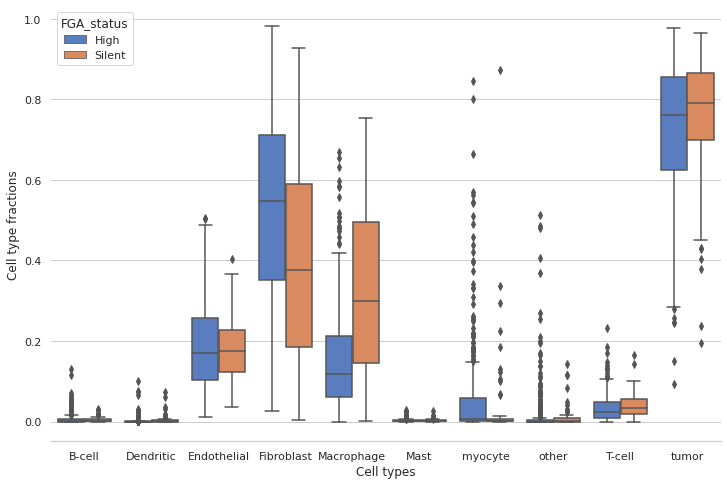

In [82]:
plt.subplots(figsize=(12,8))
sns.boxplot(x='variable',y='value',hue='FGA_status',data=df_merged_HPVneg_melt)
sns.despine(left=True)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

Text(0, 0.5, 'Cell type fractions')

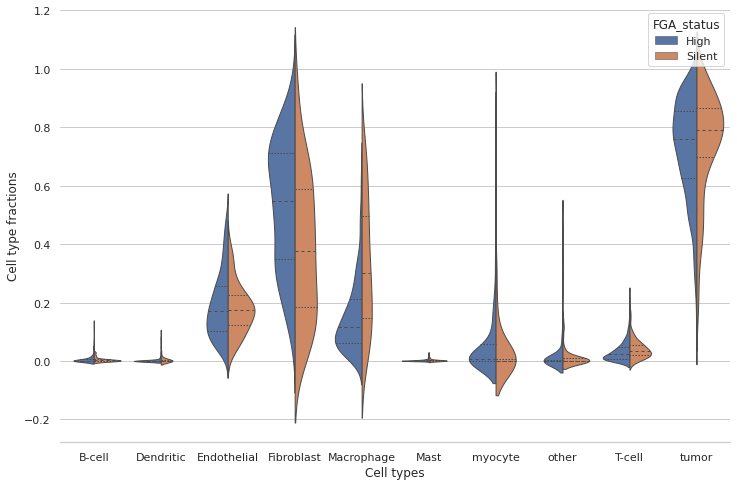

In [83]:
plt.subplots(figsize=(12,8))
sns.set_theme(style="whitegrid")
sns.violinplot(x='variable',y='value',hue='FGA_status',data=df_merged_HPVneg_melt,split=True, inner="quart", linewidth=1,)
sns.despine(left=True)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

In [66]:
## Vis Methods below need resampling!
# SMOTE upsample CNA silent group

sm = imblearn.over_sampling.SMOTE()
list_col = df_merged_HPVneg_relative.columns[:10].tolist()
list_col.append('fga')

X_train, y_train = sm.fit_resample(df_merged_HPVneg_relative.loc[:,list_col].to_numpy(),df_merged_HPVneg_relative['FGA_status'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 716
High      358
Silent    358
Name: FGA_status, dtype: int64


In [67]:
df_afterSMOTE = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE['FGA_status'] = y_train
df_afterSMOTE

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,fga,FGA_status
0,0.000027,0.000095,0.244119,0.283693,0.309965,0.003196,0.093563,2.613147e-04,0.065081,0.911705,0.526000,High
1,0.005081,0.001320,0.257672,0.114200,0.444937,0.026182,0.000458,4.884700e-02,0.101304,0.942004,0.169000,Silent
2,0.005784,0.001777,0.063026,0.671513,0.237871,0.001418,0.000739,5.536522e-07,0.017871,0.430702,0.170000,Silent
3,0.000004,0.000002,0.199913,0.496639,0.037901,0.001111,0.257303,2.859005e-06,0.007125,0.549231,0.650000,High
4,0.002827,0.000006,0.224973,0.256350,0.159039,0.000825,0.341099,4.595136e-06,0.014877,0.680641,0.430000,High
...,...,...,...,...,...,...,...,...,...,...,...,...
711,0.002576,0.001813,0.085857,0.550522,0.337219,0.001155,0.004837,1.270033e-06,0.016020,0.428405,0.177243,Silent
712,0.006343,0.010441,0.188452,0.155404,0.501746,0.009110,0.000282,2.781475e-04,0.127943,0.813747,0.047420,Silent
713,0.005719,0.001422,0.132963,0.324149,0.486276,0.000102,0.001080,4.783774e-04,0.047811,0.736831,0.115375,Silent
714,0.017021,0.000017,0.142163,0.514065,0.255900,0.001573,0.022079,2.184862e-03,0.044997,0.567410,0.094743,Silent


In [68]:
df_afterSMOTE_melt = pd.melt(df_afterSMOTE,id_vars='FGA_status',value_vars=df_merged_HPVneg.columns[:10].tolist())
df_afterSMOTE_melt

,FGA_status,variable,value
0,High,B-cell,0.000027
1,Silent,B-cell,0.005081
2,Silent,B-cell,0.005784
3,High,B-cell,0.000004
4,High,B-cell,0.002827
...,...,...,...
7155,Silent,tumor,0.428405
7156,Silent,tumor,0.813747
7157,Silent,tumor,0.736831
7158,Silent,tumor,0.567410


In [69]:
df_afterSMOTE_melt_log = df_afterSMOTE_melt.copy()
df_afterSMOTE_melt_log['value'] = df_afterSMOTE_melt_log['value'].apply(np.log)

[Text(0.5, 0, 'Cell type percentage SWARMs after SMOTE resampling')]

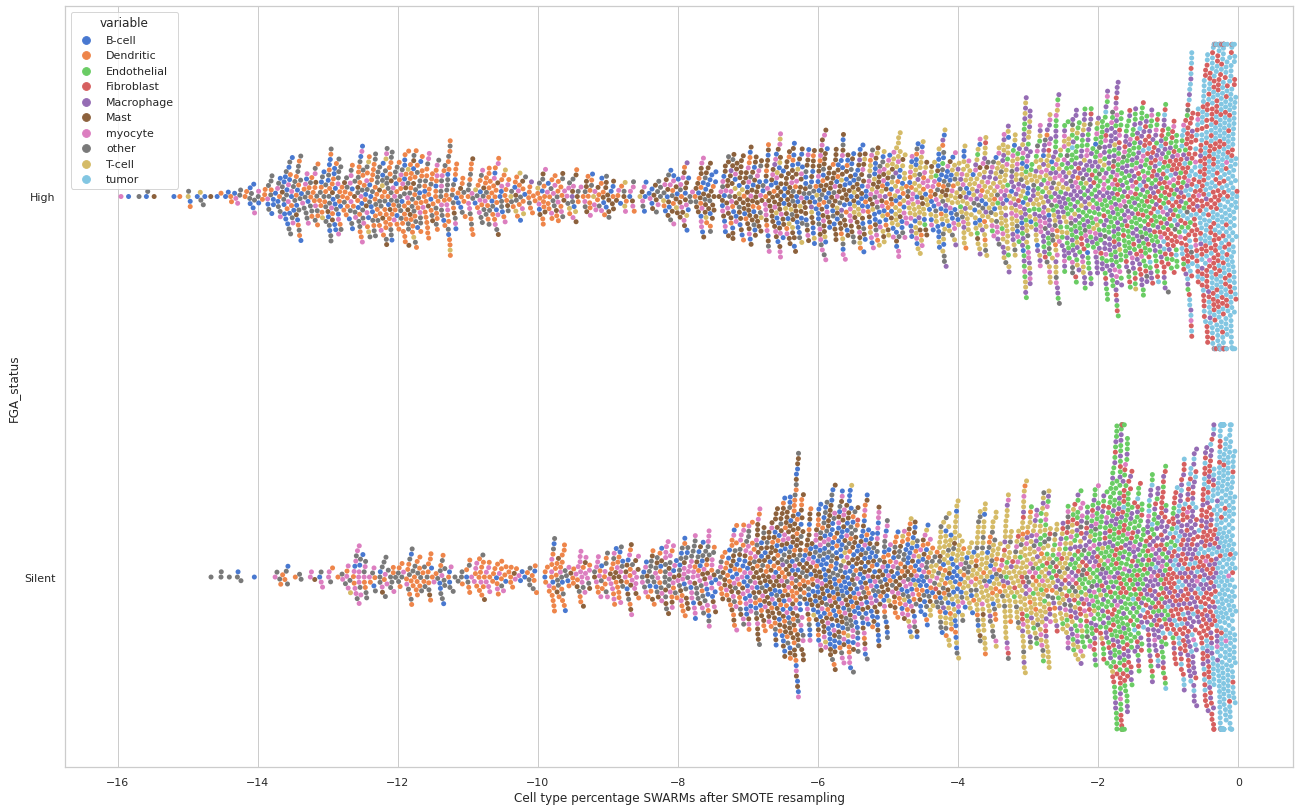

In [71]:
# Draw a categorical scatterplot to show each observation
plt.subplots(figsize=(22,14))
sns.set_theme(style="whitegrid", palette="muted")
ax = sns.swarmplot(data=df_afterSMOTE_melt_log, x="value", y="FGA_status", hue="variable")
ax.set(xlabel="Cell type percentage SWARMs after SMOTE resampling")

In [72]:
# pca and minmax scale
mmscaler = MinMaxScaler()

[0.52925429]


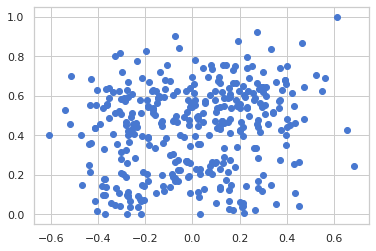

In [73]:
df_mat = df_afterSMOTE[df_afterSMOTE['FGA_status']=='High'].drop(['FGA_status','fga'],axis=1)
pca = PCA(n_components=1)
pca.fit(df_mat)
print(pca.explained_variance_ratio_)
plt.scatter(pca.transform(df_mat),mmscaler.fit_transform(df_afterSMOTE[df_afterSMOTE['FGA_status']=='High']['fga'].values.reshape(-1,1)))

[0.60856289]


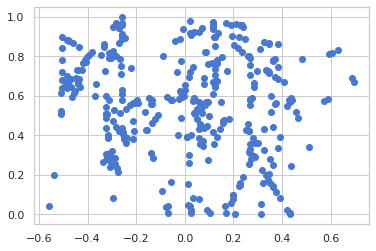

In [74]:
df_mat = df_afterSMOTE[df_afterSMOTE['FGA_status']=='Silent'].drop(['FGA_status','fga'],axis=1)
pca = PCA(n_components=1)
pca.fit(df_mat)
print(pca.explained_variance_ratio_)
plt.scatter(pca.transform(df_mat),mmscaler.fit_transform(df_afterSMOTE[df_afterSMOTE['FGA_status']=='Silent']['fga'].values.reshape(-1,1)))

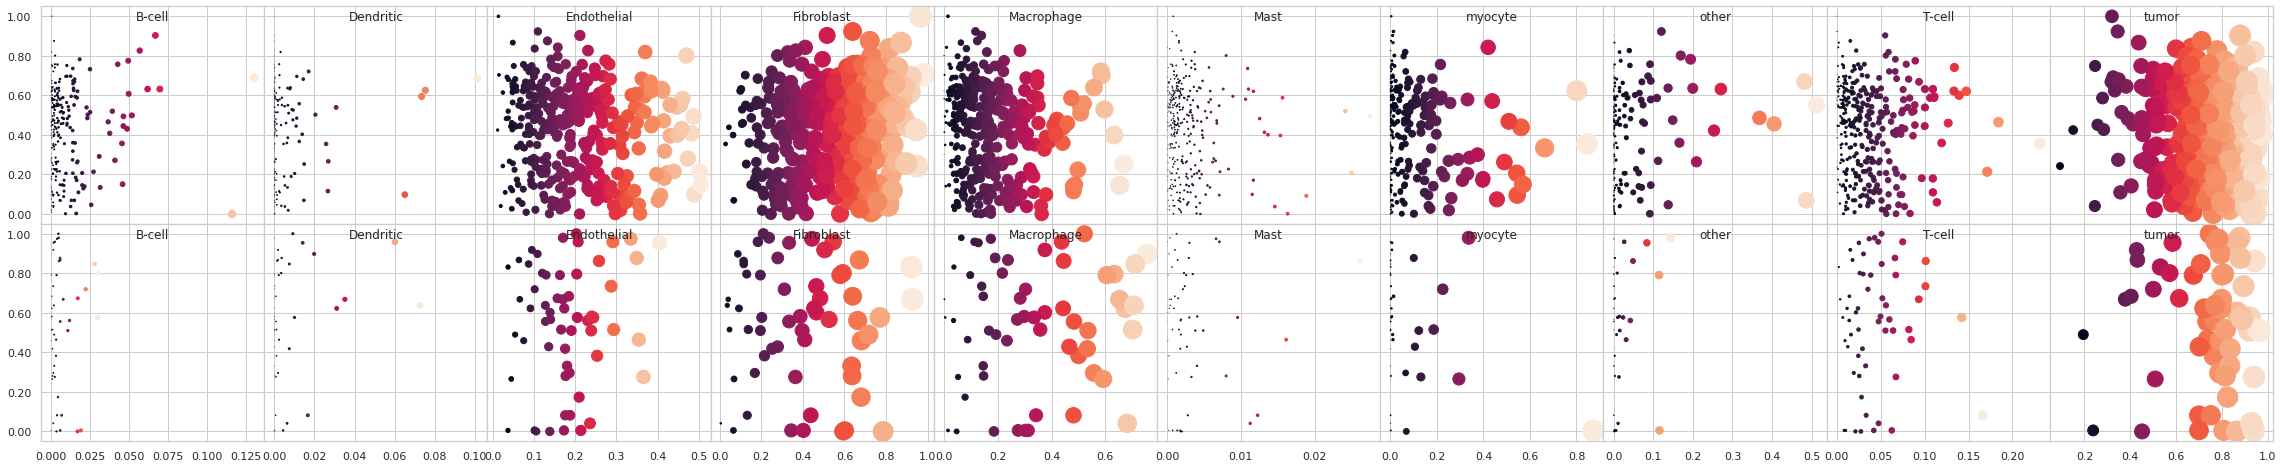

In [77]:
# Visualize fga distribution between CNA high vs silent groups and cell type compostions
fig,ax = plt.subplots(2,10,figsize=(40,8),sharey='row',sharex='col')
mmscaler = MinMaxScaler()
celltypecount = 10
count=0
for i in df_merged.columns[:celltypecount]:
    y = mmscaler.fit_transform(df_merged_HPVneg_relative['fga'][df_merged_HPVneg_relative['FGA_status']=='High'].values.reshape(-1,1))
#     x = df_merged['cellularity'][df_merged['FGA_status']=='High']
    z = df_merged_HPVneg_relative[i][df_merged_HPVneg_relative['FGA_status']=='High']
    ax[0,count].scatter(z,y,c=z,s=z*500)
    ax[0,count].set_title(i,y=1.0, pad=-14)
    ax[0,count].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    count+=1
count=0

for i in df_merged.columns[:celltypecount]:
    y = mmscaler.fit_transform(df_merged_HPVneg_relative['fga'][df_merged_HPVneg_relative['FGA_status']=='Silent'].values.reshape(-1,1))
#     x = df_merged['cellularity'][df_merged['FGA_status']=='Silent']
    z = df_merged_HPVneg_relative[i][df_merged_HPVneg_relative['FGA_status']=='Silent']
    ax[1,count].scatter(z,y,c=z,s=z*500)
    ax[1,count].set_title(i,y=1.0, pad=-14)
    ax[1,count].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    count+=1
count=0

plt.subplots_adjust(wspace=0, hspace=0)


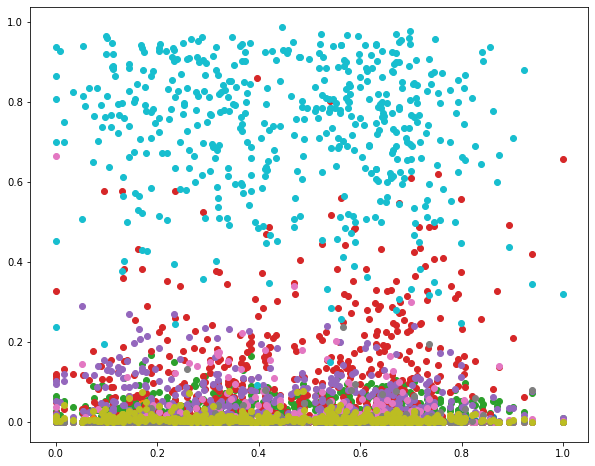

In [62]:
fig,ax = plt.subplots(figsize=(10,8))

celltypecount = 10
for i in df_afterSMOTE_melt_log.columns[:celltypecount]:
    x = df_afterSMOTE_melt_log['fga'].tolist()
    y = df_afterSMOTE_melt_log.loc[:,i]
    ax.scatter(x, y)


## Anatomical sites
-	Anatomical locations in groups on the x-axis and see for each (immune) cell type whether there are significant differences between anatomical sites (oral cavity, hypopharynx, larynx, oropharynx), all HPV-negative 

In [48]:
TCGA_clinical = pd.read_csv("/home/cke/TCGA_HNSCC_clinical_data.tsv",sep='\t')
TCGA_clinical['Patient Primary Tumor Site'].value_counts()

Oral Tongue       133
Larynx            117
Oral Cavity        73
Floor of mouth     64
Tonsil             46
Base of tongue     27
Buccal Mucosa      23
Alveolar Ridge     18
Hypopharynx        10
Oropharynx          9
Hard Palate         7
Lip                 3
Name: Patient Primary Tumor Site, dtype: int64

In [78]:
TCGA_pheno

,submitter_id.samples,additional_pharmaceutical_therapy,additional_radiation_therapy,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,amount_of_alcohol_consumption_per_day,batch_number,bcr,bcr_followup_barcode,...,longest_dimension.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,shortest_dimension.samples,state.samples,tissue_type.samples,hpv_status,sample
0,TCGA-DQ-5631-01A,YES,YES,NaN,NO,52.0,1.0,145.84.0,Nationwide Children's Hospital,TCGA-DQ-5631-F10177,...,0.5,NaN,NaN,Primary Tumor,1,0.1,released,Not Reported,,TCGA-DQ-5631
1,TCGA-BA-7269-01A,NaN,NaN,NaN,NaN,61.0,2.0,164.84.0,Nationwide Children's Hospital,TCGA-BA-7269-F70239,...,1.2,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported,,TCGA-BA-7269
2,TCGA-BA-A4IH-01A,NaN,NaN,NaN,NaN,57.0,4.0,273.58.0,Nationwide Children's Hospital,TCGA-BA-A4IH-F57559,...,NaN,False,NaN,Primary Tumor,1,NaN,released,Not Reported,Negative,TCGA-BA-A4IH
3,TCGA-CV-6954-01A,NaN,NaN,NaN,NaN,59.0,3.0,151.75.0,Nationwide Children's Hospital,TCGA-CV-6954-F45240,...,1.3,NaN,NaN,Primary Tumor,1,0.4,released,Not Reported,,TCGA-CV-6954
4,TCGA-CV-6954-11A,NaN,NaN,NaN,NaN,59.0,3.0,151.75.0,Nationwide Children's Hospital,TCGA-CV-6954-F45240,...,1.3,NaN,NaN,Solid Tissue Normal,11,0.6,released,Not Reported,,TCGA-CV-6954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,TCGA-HD-A6I0-01A,NaN,NaN,NaN,NaN,56.0,4.0,318.55.0,Nationwide Children's Hospital,TCGA-HD-A6I0-F66034,...,NaN,False,NaN,Primary Tumor,1,NaN,released,Not Reported,,TCGA-HD-A6I0
608,TCGA-HD-A6I0-11A,NaN,NaN,NaN,NaN,56.0,4.0,318.55.0,Nationwide Children's Hospital,TCGA-HD-A6I0-F66034,...,NaN,False,NaN,Solid Tissue Normal,11,NaN,released,Not Reported,,TCGA-HD-A6I0
609,TCGA-BA-4077-01B,YES,NO,NaN,NaN,45.0,0.0,54.89.0,Nationwide Children's Hospital,TCGA-BA-4077-F9954,...,0.7,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported,,TCGA-BA-4077
610,TCGA-IQ-7630-01A,NaN,NaN,NaN,NaN,49.0,NaN,188.78.0,Nationwide Children's Hospital,TCGA-IQ-7630-F36191,...,NaN,NaN,NaN,Primary Tumor,1,NaN,released,Not Reported,,TCGA-IQ-7630


In [45]:
TCGA_pheno['primary_site'].value_counts()

Other and unspecified parts of tongue                                   158
Larynx                                                                  144
Other and ill-defined sites in lip, oral cavity and pharynx              90
Floor of mouth                                                           62
Tonsil                                                                   47
Other and unspecified parts of mouth                                     44
Base of tongue                                                           27
Gum                                                                      11
Oropharynx                                                               10
Hypopharynx                                                               9
Palate                                                                    6
Lip                                                                       3
Bones, joints and articular cartilage of other and unspecified sites      1
Name: primar

In [191]:
df_merged_sites = pd.merge(res_prevail,TCGA_pheno[['submitter_id.samples','primary_site']],left_index=True,right_on='submitter_id.samples')
df_merged_sites

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,submitter_id.samples,primary_site
556,2.411960e-06,8.428294e-06,0.021554,0.025049,0.027368,0.000282,8.261100e-03,2.307278e-05,0.005746,0.911705,TCGA-BB-4224-01,TCGA-BB-4224-01A,Other and unspecified parts of tongue
140,2.946835e-04,7.654396e-05,0.014944,0.006623,0.025805,0.001518,2.656234e-05,2.832948e-03,0.005875,0.942004,TCGA-H7-7774-01,TCGA-H7-7774-01A,"Other and ill-defined sites in lip, oral cavit..."
327,3.293064e-03,1.011790e-03,0.035880,0.382291,0.135420,0.000807,4.207604e-04,3.151934e-07,0.010174,0.430702,TCGA-CV-6943-01,TCGA-CV-6943-01A,Base of tongue
175,5.709435e-03,3.259289e-03,0.037323,0.027008,0.052619,0.000677,1.216315e-02,2.098187e-06,0.028711,0.832527,TCGA-CN-5374-01,TCGA-CN-5374-01A,Tonsil
412,1.749130e-06,8.105416e-07,0.090115,0.223870,0.017085,0.000501,1.159842e-01,1.288752e-06,0.003212,0.549231,TCGA-CQ-6227-01,TCGA-CQ-6227-01A,"Other and ill-defined sites in lip, oral cavit..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2.447322e-07,5.819924e-06,0.046802,0.340756,0.052835,0.000410,2.725393e-07,5.001734e-07,0.007906,0.551284,TCGA-CV-7235-01,TCGA-CV-7235-01A,Floor of mouth
94,1.076841e-03,1.317807e-04,0.031584,0.020308,0.012922,0.000071,3.760127e-04,3.780077e-04,0.006510,0.926642,TCGA-CX-7086-01,TCGA-CX-7086-01A,Floor of mouth
354,1.406815e-04,1.252411e-06,0.025322,0.012222,0.019459,0.000512,1.774254e-05,8.328643e-02,0.001632,0.857408,TCGA-CV-6935-11,TCGA-CV-6935-11A,Larynx
530,2.015405e-02,1.773918e-03,0.049495,0.094740,0.074611,0.003291,9.269963e-05,2.502143e-06,0.022013,0.733826,TCGA-P3-A6SW-01,TCGA-P3-A6SW-01A,Tonsil


In [192]:
df_merged_sites_HPVpos = df_merged_sites.copy()
df_merged_sites_HPVpos['sample_match'] = df_merged_sites['sample'].str.rsplit("-",n=1,expand=True)[0]
df_merged_sites_HPVpos = df_merged_sites_HPVpos[df_merged_sites_HPVpos['sample_match'].isin(set_pos)]
df_merged_sites_HPVpos

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,submitter_id.samples,primary_site,sample_match
175,5.709435e-03,3.259289e-03,0.037323,0.027008,0.052619,6.771725e-04,1.216315e-02,2.098187e-06,2.871072e-02,8.325270e-01,TCGA-CN-5374-01,TCGA-CN-5374-01A,Tonsil,TCGA-CN-5374
59,8.058788e-03,4.823114e-03,0.053060,0.050577,0.088309,1.368717e-03,9.219069e-07,1.354588e-06,3.146223e-02,7.623381e-01,TCGA-CR-5249-01,TCGA-CR-5249-01A,Tonsil,TCGA-CR-5249
498,7.443090e-07,3.121541e-07,0.040349,0.036785,0.002363,3.820756e-07,7.366317e-01,1.838684e-01,3.759763e-07,8.381374e-07,TCGA-CV-6939-11,TCGA-CV-6939-11A,Other and unspecified parts of tongue,TCGA-CV-6939
148,5.152614e-07,8.190410e-03,0.062263,0.205726,0.042858,1.320542e-04,1.670411e-06,9.878747e-07,7.813216e-03,6.730147e-01,TCGA-CV-7100-01,TCGA-CV-7100-01A,"Other and ill-defined sites in lip, oral cavit...",TCGA-CV-7100
557,3.396785e-03,4.164090e-02,0.040713,0.013894,0.158393,1.626501e-04,6.779418e-04,1.593186e-06,4.158528e-02,6.995350e-01,TCGA-CV-6433-01,TCGA-CV-6433-01A,Other and unspecified parts of tongue,TCGA-CV-6433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,9.708422e-04,1.947348e-06,0.025515,0.137947,0.006925,6.830365e-04,6.394477e-04,1.926546e-06,4.616617e-03,8.226989e-01,TCGA-CR-6472-01,TCGA-CR-6472-01A,Base of tongue,TCGA-CR-6472
400,8.084122e-04,1.329103e-06,0.028775,0.153656,0.042174,3.387214e-04,2.762348e-07,2.939319e-05,1.475812e-02,7.594585e-01,TCGA-CR-6471-01,TCGA-CR-6471-01A,"Other and ill-defined sites in lip, oral cavit...",TCGA-CR-6471
434,3.712345e-04,9.509487e-03,0.013387,0.003488,0.048337,3.362877e-04,4.518488e-04,7.850974e-07,1.089785e-02,9.132204e-01,TCGA-KU-A6H7-06,TCGA-KU-A6H7-06A,Tonsil,TCGA-KU-A6H7
126,7.911152e-03,1.479327e-03,0.059608,0.055123,0.079095,9.063200e-04,2.255429e-04,1.704567e-05,2.031475e-02,7.753192e-01,TCGA-CR-7404-01,TCGA-CR-7404-01A,Tonsil,TCGA-CR-7404


In [194]:
# we will only use HPV- samples here
df_merged_sites_HPVneg = df_merged_sites.copy()
df_merged_sites_HPVneg['sample_match'] = df_merged_sites['sample'].str.rsplit("-",n=1,expand=True)[0]
df_merged_sites_HPVneg = df_merged_sites_HPVneg[~df_merged_sites_HPVneg['sample_match'].isin(set_pos)]
df_merged_sites_HPVneg

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,submitter_id.samples,primary_site,sample_match
556,2.411960e-06,8.428294e-06,0.021554,0.025049,0.027368,0.000282,8.261100e-03,2.307278e-05,0.005746,0.911705,TCGA-BB-4224-01,TCGA-BB-4224-01A,Other and unspecified parts of tongue,TCGA-BB-4224
140,2.946835e-04,7.654396e-05,0.014944,0.006623,0.025805,0.001518,2.656234e-05,2.832948e-03,0.005875,0.942004,TCGA-H7-7774-01,TCGA-H7-7774-01A,"Other and ill-defined sites in lip, oral cavit...",TCGA-H7-7774
327,3.293064e-03,1.011790e-03,0.035880,0.382291,0.135420,0.000807,4.207604e-04,3.151934e-07,0.010174,0.430702,TCGA-CV-6943-01,TCGA-CV-6943-01A,Base of tongue,TCGA-CV-6943
412,1.749130e-06,8.105416e-07,0.090115,0.223870,0.017085,0.000501,1.159842e-01,1.288752e-06,0.003212,0.549231,TCGA-CQ-6227-01,TCGA-CQ-6227-01A,"Other and ill-defined sites in lip, oral cavit...",TCGA-CQ-6227
217,9.027032e-04,1.887428e-06,0.071847,0.081868,0.050790,0.000264,1.089332e-01,1.467499e-06,0.004751,0.680641,TCGA-CV-6959-01,TCGA-CV-6959-01A,Other and unspecified parts of tongue,TCGA-CV-6959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,2.368614e-07,6.724227e-07,0.020278,0.019954,0.003087,0.000407,6.702224e-01,2.450983e-03,0.000269,0.283331,TCGA-WA-A7GZ-11,TCGA-WA-A7GZ-11A,Floor of mouth,TCGA-WA-A7GZ
144,2.447322e-07,5.819924e-06,0.046802,0.340756,0.052835,0.000410,2.725393e-07,5.001734e-07,0.007906,0.551284,TCGA-CV-7235-01,TCGA-CV-7235-01A,Floor of mouth,TCGA-CV-7235
94,1.076841e-03,1.317807e-04,0.031584,0.020308,0.012922,0.000071,3.760127e-04,3.780077e-04,0.006510,0.926642,TCGA-CX-7086-01,TCGA-CX-7086-01A,Floor of mouth,TCGA-CX-7086
354,1.406815e-04,1.252411e-06,0.025322,0.012222,0.019459,0.000512,1.774254e-05,8.328643e-02,0.001632,0.857408,TCGA-CV-6935-11,TCGA-CV-6935-11A,Larynx,TCGA-CV-6935


In [208]:
df_merged_sites_HPVneg['primary_site'].value_counts()
# need to filter out sites with too less samples

Other and unspecified parts of tongue                                   131
Larynx                                                                  120
Other and ill-defined sites in lip, oral cavity and pharynx              77
Floor of mouth                                                           56
Other and unspecified parts of mouth                                     41
Base of tongue                                                           11
Gum                                                                       8
Tonsil                                                                    7
Hypopharynx                                                               7
Oropharynx                                                                7
Palate                                                                    4
Lip                                                                       3
Bones, joints and articular cartilage of other and unspecified sites      1
Name: primar

In [227]:
# remove primary site with sample counts<=10
df_merged_sites_HPVneg_filtered = df_merged_sites_HPVneg.groupby("primary_site").filter(lambda x: len(x) >10)
df_merged_sites_HPVneg_filtered['primary_site'].value_counts()

Other and unspecified parts of tongue                          131
Larynx                                                         120
Other and ill-defined sites in lip, oral cavity and pharynx     77
Floor of mouth                                                  56
Other and unspecified parts of mouth                            41
Base of tongue                                                  11
Name: primary_site, dtype: int64

In [230]:
df_merged_sites_HPVneg_melt = pd.melt(df_merged_sites_HPVneg_filtered,id_vars='primary_site',value_vars=df_merged_sites_HPVneg.columns[:10].tolist())
df_merged_sites_HPVneg_melt

,primary_site,variable,value
0,Other and unspecified parts of tongue,B-cell,0.000002
1,"Other and ill-defined sites in lip, oral cavit...",B-cell,0.000295
2,Base of tongue,B-cell,0.003293
3,"Other and ill-defined sites in lip, oral cavit...",B-cell,0.000002
4,Other and unspecified parts of tongue,B-cell,0.000903
...,...,...,...
4355,Floor of mouth,tumor,0.283331
4356,Floor of mouth,tumor,0.551284
4357,Floor of mouth,tumor,0.926642
4358,Larynx,tumor,0.857408


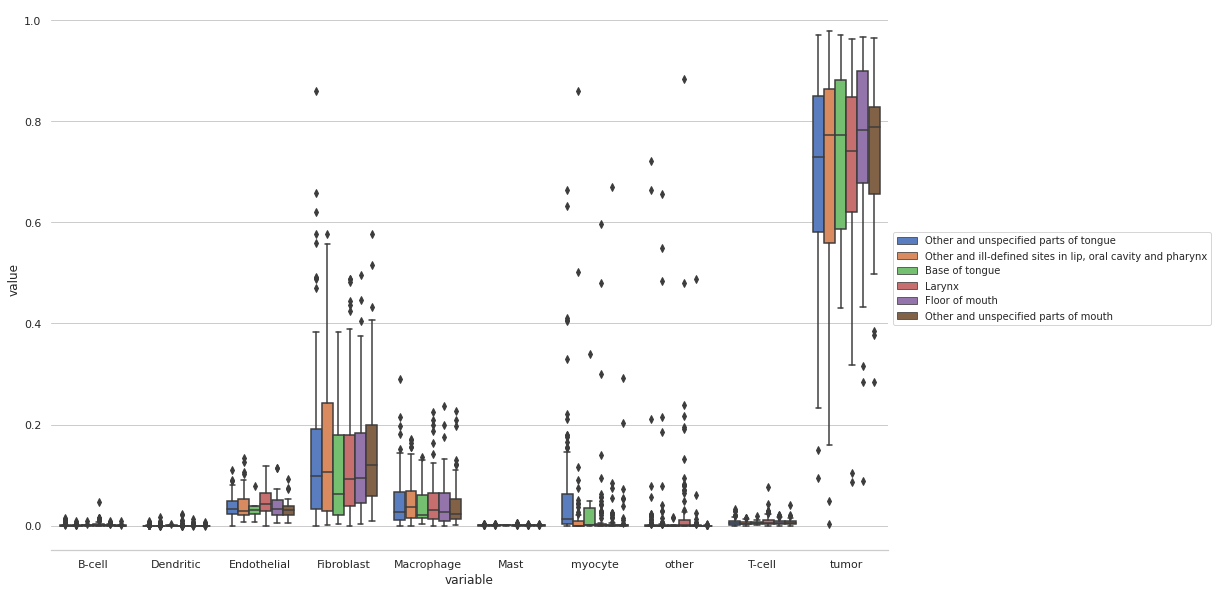

In [257]:
plt.subplots(figsize=(15,10))
sns.boxplot(x='variable',y='value',hue='primary_site',data=df_merged_sites_HPVneg_melt)
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=10)

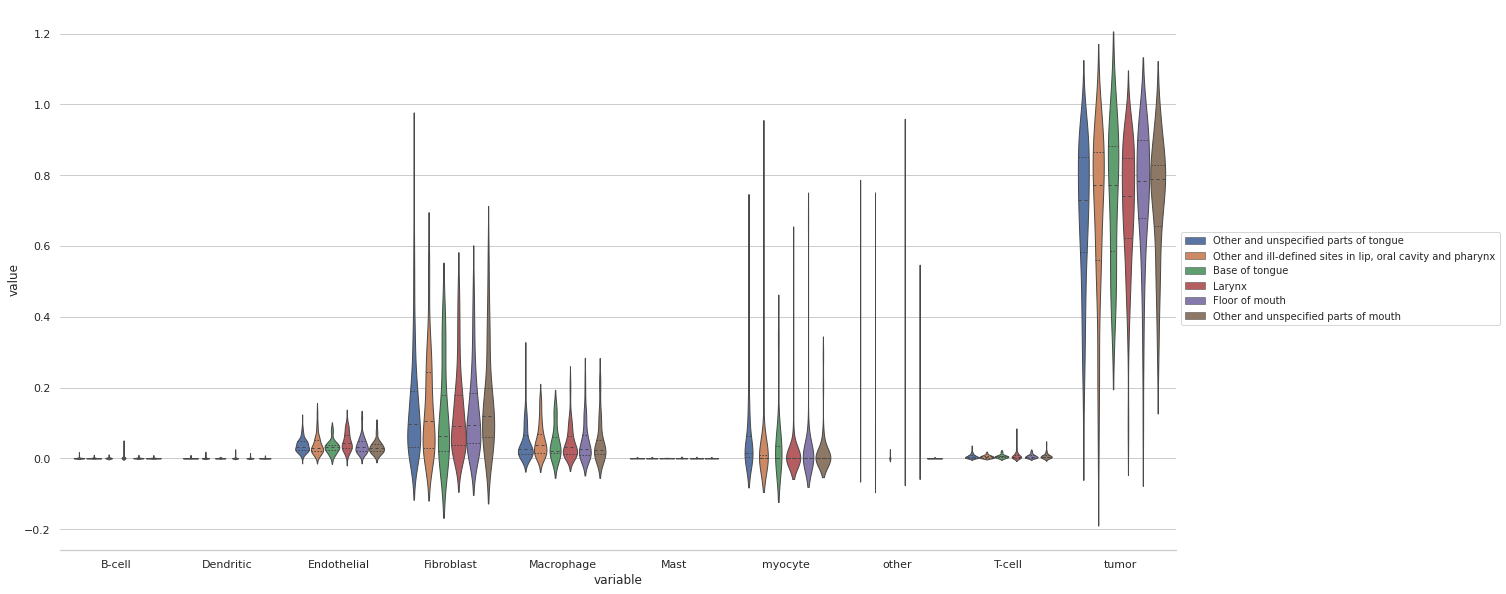

In [258]:
plt.subplots(figsize=(20,10))
sns.set_theme(style="whitegrid")
sns.violinplot(x='variable',y='value',hue='primary_site',data=df_merged_sites_HPVneg_melt, inner="quart", linewidth=1,)
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=10)

In [234]:
## Vis Methods below need resampling!
# SMOTE upsample CNA silent group

sm = imblearn.over_sampling.SMOTE()
list_col = df_merged_sites_HPVneg.columns[:10].tolist()

X_train, y_train = sm.fit_resample(df_merged_sites_HPVneg_filtered.loc[:,list_col].to_numpy(),df_merged_sites_HPVneg_filtered['primary_site'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 786
Other and unspecified parts of tongue                          131
Other and ill-defined sites in lip, oral cavity and pharynx    131
Base of tongue                                                 131
Larynx                                                         131
Floor of mouth                                                 131
Other and unspecified parts of mouth                           131
Name: primary_site, dtype: int64


In [235]:
df_afterSMOTE_site = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE_site['primary_site'] = y_train
df_afterSMOTE_site

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,primary_site
0,2.411960e-06,8.428294e-06,0.021554,0.025049,0.027368,0.000282,8.261100e-03,2.307278e-05,0.005746,0.911705,Other and unspecified parts of tongue
1,2.946835e-04,7.654396e-05,0.014944,0.006623,0.025805,0.001518,2.656234e-05,2.832948e-03,0.005875,0.942004,"Other and ill-defined sites in lip, oral cavit..."
2,3.293064e-03,1.011790e-03,0.035880,0.382291,0.135420,0.000807,4.207604e-04,3.151934e-07,0.010174,0.430702,Base of tongue
3,1.749130e-06,8.105416e-07,0.090115,0.223870,0.017085,0.000501,1.159842e-01,1.288752e-06,0.003212,0.549231,"Other and ill-defined sites in lip, oral cavit..."
4,9.027032e-04,1.887428e-06,0.071847,0.081868,0.050790,0.000264,1.089332e-01,1.467499e-06,0.004751,0.680641,Other and unspecified parts of tongue
...,...,...,...,...,...,...,...,...,...,...,...
781,4.165022e-04,2.657694e-06,0.012170,0.035089,0.002948,0.000512,5.180573e-04,1.270989e-03,0.002106,0.944967,Other and unspecified parts of mouth
782,8.411190e-05,7.384229e-06,0.019464,0.021988,0.015000,0.000227,5.101948e-04,5.042365e-05,0.004516,0.938153,Other and unspecified parts of mouth
783,4.941779e-04,1.551269e-06,0.031851,0.110560,0.005488,0.000344,9.020490e-04,3.585688e-04,0.003458,0.846543,Other and unspecified parts of mouth
784,7.707735e-07,1.969142e-06,0.040356,0.337050,0.021801,0.000375,4.808330e-02,9.994771e-07,0.004528,0.547803,Other and unspecified parts of mouth


In [237]:
df_afterSMOTE_melt_site = pd.melt(df_afterSMOTE_site,id_vars='primary_site',value_vars=df_merged_sites_HPVneg_filtered.columns[:10].tolist())
df_afterSMOTE_melt_site

,primary_site,variable,value
0,Other and unspecified parts of tongue,B-cell,0.000002
1,"Other and ill-defined sites in lip, oral cavit...",B-cell,0.000295
2,Base of tongue,B-cell,0.003293
3,"Other and ill-defined sites in lip, oral cavit...",B-cell,0.000002
4,Other and unspecified parts of tongue,B-cell,0.000903
...,...,...,...
7855,Other and unspecified parts of mouth,tumor,0.944967
7856,Other and unspecified parts of mouth,tumor,0.938153
7857,Other and unspecified parts of mouth,tumor,0.846543
7858,Other and unspecified parts of mouth,tumor,0.547803


In [239]:
df_afterSMOTE_melt_site_log = df_afterSMOTE_melt_site.copy()
df_afterSMOTE_melt_site_log['value'] = df_afterSMOTE_melt_site_log['value'].apply(np.log)

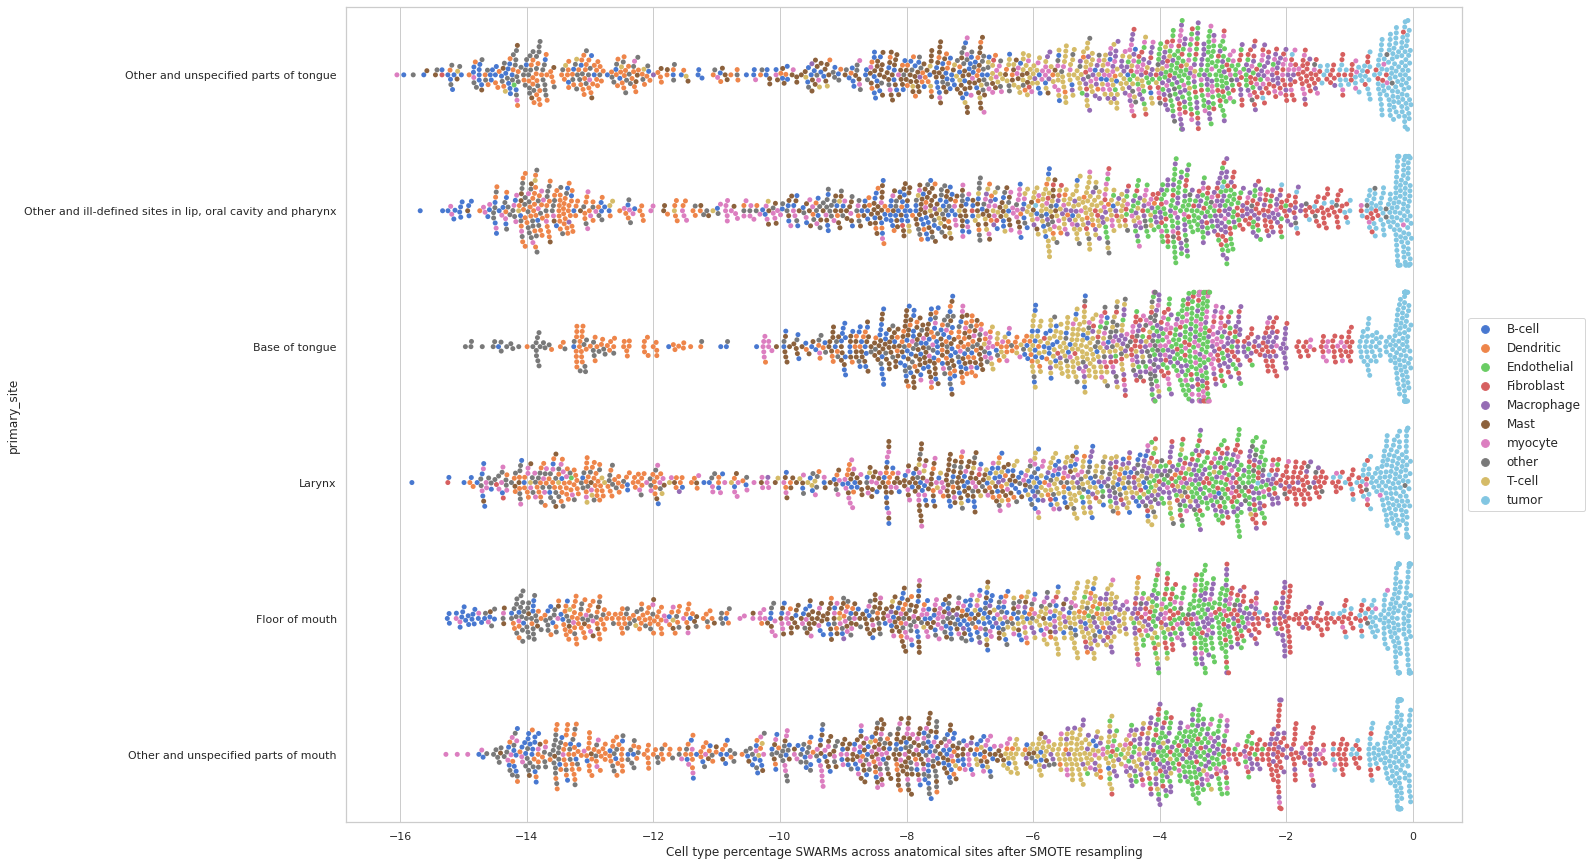

In [259]:
# Draw a categorical scatterplot to show each observation
plt.subplots(figsize=(20,15))
sns.set_theme(style="whitegrid", palette="muted")
ax = sns.swarmplot(data=df_afterSMOTE_melt_site_log, x="value", y="primary_site", hue="variable")
ax.set(xlabel="Cell type percentage SWARMs across anatomical sites after SMOTE resampling")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)

###	HPV-positive versus HPV-negative oropharynx tumors (no other anatomical sites here)

In [162]:
list_oropharynx = TCGA_pheno[TCGA_pheno['primary_site']=='Oropharynx']['sample'].tolist()
list_oropharynx

['TCGA-HD-7753',
 'TCGA-BA-A8YP',
 'TCGA-QK-A8ZA',
 'TCGA-MZ-A6I9',
 'TCGA-IQ-A61O',
 'TCGA-BA-A4IF',
 'TCGA-BA-A4II',
 'TCGA-BA-A4IG',
 'TCGA-BA-A6DL',
 'TCGA-IQ-7630']

In [214]:
df_oro_pos = df_merged_sites_HPVpos[df_merged_sites_HPVpos['sample_match'].isin(list_oropharynx)]
df_oro_pos.loc[:,'hpv_status'] = 'Positive'

/tmp/ipykernel_25875/3430342558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oro_pos.loc[:,'hpv_status'] = 'Positive'


In [215]:
df_oro_neg = df_merged_sites_HPVneg[df_merged_sites_HPVneg['sample_match'].isin(list_oropharynx)]
df_oro_neg.loc[:,'hpv_status'] = 'Negative'

/tmp/ipykernel_25875/1329020625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oro_neg.loc[:,'hpv_status'] = 'Negative'


In [216]:
df_oro = pd.concat([df_oro_neg,df_oro_pos],axis=0)
df_oro

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,submitter_id.samples,primary_site,sample_match,hpv_status
403,1.041429e-04,2.098840e-06,0.033728,0.105453,0.004813,0.000022,7.624504e-03,8.875180e-03,4.095191e-03,0.835283,TCGA-BA-A4IF-01,TCGA-BA-A4IF-01A,Oropharynx,TCGA-BA-A4IF,Negative
610,2.449608e-07,1.609777e-06,0.013902,0.135830,0.032781,0.000121,2.594291e-04,6.004832e-07,5.933681e-03,0.811170,TCGA-IQ-7630-01,TCGA-IQ-7630-01A,Oropharynx,TCGA-IQ-7630,Negative
406,1.667045e-03,3.443472e-06,0.043618,0.118541,0.023005,0.000103,7.248379e-07,3.404526e-06,1.031562e-02,0.802743,TCGA-BA-A4II-01,TCGA-BA-A4II-01A,Oropharynx,TCGA-BA-A4II,Negative
130,2.383724e-03,9.814999e-07,0.031160,0.431659,0.028496,0.000024,5.554698e-03,6.795289e-07,8.424196e-04,0.499879,TCGA-BA-A8YP-01,TCGA-BA-A8YP-01A,Oropharynx,TCGA-BA-A8YP,Negative
492,1.310547e-03,1.037136e-05,0.019906,0.026457,0.003594,0.000242,4.530845e-04,5.146560e-06,5.799909e-03,0.942222,TCGA-BA-A6DL-01,TCGA-BA-A6DL-01A,Oropharynx,TCGA-BA-A6DL,Negative
97,4.956171e-04,1.939836e-06,0.027241,0.166810,0.011019,0.000648,8.473900e-04,5.022933e-07,9.874320e-03,0.783063,TCGA-HD-7753-01,TCGA-HD-7753-01A,Oropharynx,TCGA-HD-7753,Negative
379,1.438484e-07,2.689546e-07,0.009661,0.802536,0.036985,0.000022,5.139043e-05,1.466198e-07,3.105177e-07,0.150743,TCGA-IQ-A61O-01,TCGA-IQ-A61O-01A,Oropharynx,TCGA-IQ-A61O,Negative
277,1.125880e-02,7.668960e-06,0.045793,0.016935,0.007300,0.000775,2.235233e-03,4.812466e-03,5.009971e-03,0.905873,TCGA-MZ-A6I9-01,TCGA-MZ-A6I9-01A,Oropharynx,TCGA-MZ-A6I9,Positive
194,2.216752e-06,3.073734e-06,0.037218,0.023580,0.007484,0.000315,8.707656e-05,4.357607e-06,6.213060e-03,0.925094,TCGA-QK-A8ZA-01,TCGA-QK-A8ZA-01A,Oropharynx,TCGA-QK-A8ZA,Positive
407,2.163843e-03,4.159671e-04,0.020333,0.007674,0.022683,0.000302,1.808930e-04,2.131534e-05,1.571494e-02,0.930512,TCGA-BA-A4IG-01,TCGA-BA-A4IG-01A,Oropharynx,TCGA-BA-A4IG,Positive


In [248]:
df_oro['hpv_status'].value_counts()

Negative    7
Positive    3
Name: hpv_status, dtype: int64

In [246]:
df_oro_melt = pd.melt(df_oro,id_vars='hpv_status',value_vars=df_merged_sites_HPVneg.columns[:10].tolist())
df_oro_melt

,hpv_status,variable,value
0,Negative,B-cell,1.041429e-04
1,Negative,B-cell,2.449608e-07
2,Negative,B-cell,1.667045e-03
3,Negative,B-cell,2.383724e-03
4,Negative,B-cell,1.310547e-03
...,...,...,...
95,Negative,tumor,7.830626e-01
96,Negative,tumor,1.507430e-01
97,Positive,tumor,9.058726e-01
98,Positive,tumor,9.250935e-01


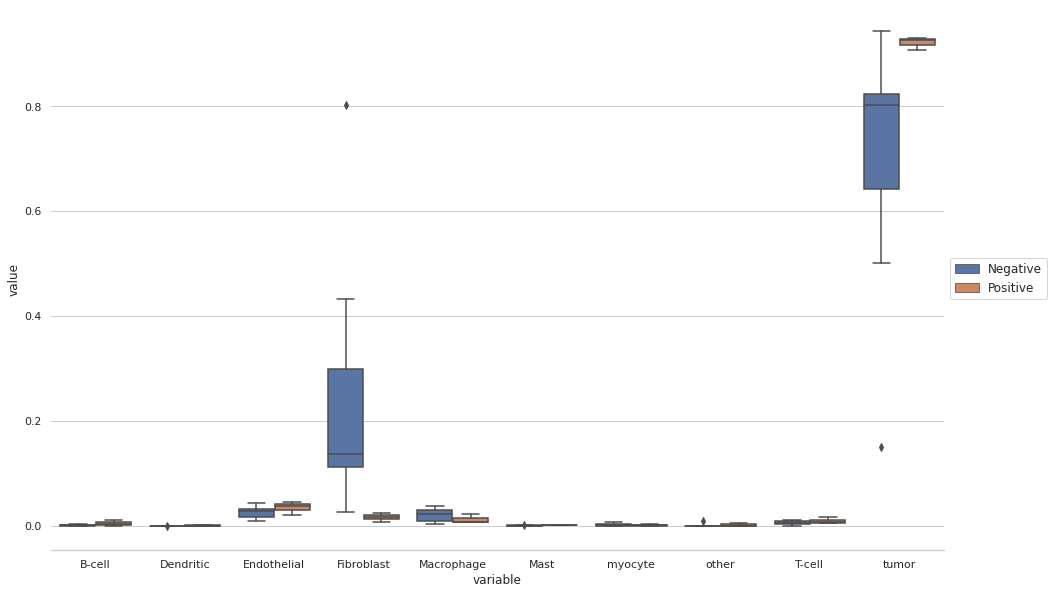

In [255]:
plt.subplots(figsize=(16,10))
sns.boxplot(x='variable',y='value',hue='hpv_status',data=df_oro_melt)
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)

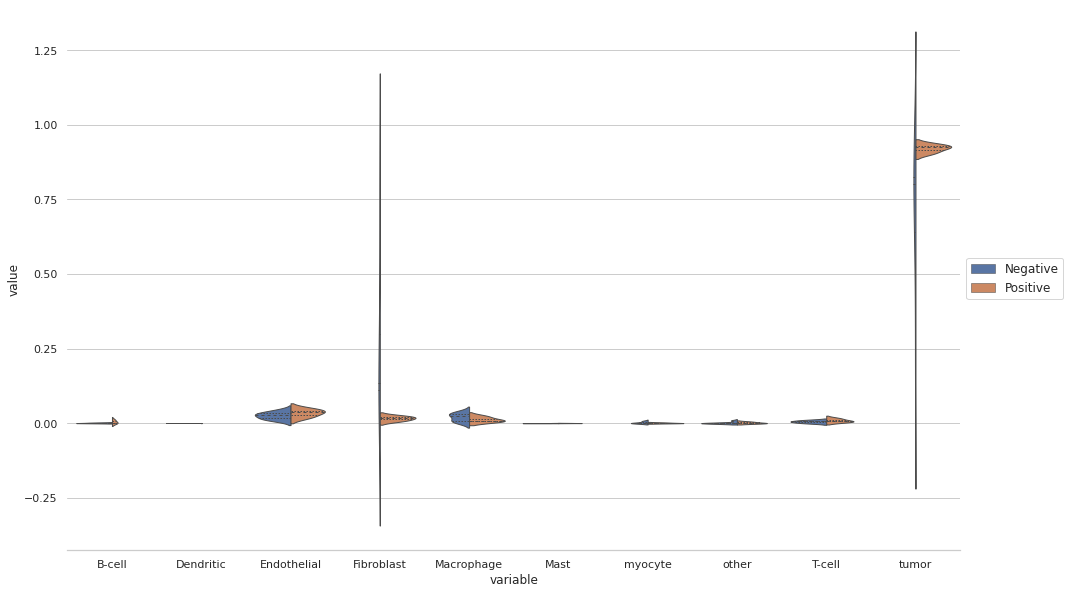

In [254]:
plt.subplots(figsize=(16,10))
sns.set_theme(style="whitegrid")
sns.violinplot(x='variable',y='value',hue='hpv_status',data=df_oro_melt, inner="quart", split=True,linewidth=1,)
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)